<center><img src="images/header.png" width=400></center>

<h1><center>Основы машинного обучения</center></h1>
<hr>
<h2><center>Методы обучения без учителя: Домашняя работа</center></h2>

Правила:

* Отчеты принимаются до 23:59 11 апреля. Вы должны залить ваш ноутбук в [colab](https://colab.research.google.com) и дать на него ссылку в форме сдачи ДЗ на портале
* Работоспособность будет проверяться в коллабе. Это значит что:
    1. Вам надо удостовериться, что код отрабатывает от начала и до конца. Выполните аналог "Restart Kernel and Run All" в colab
    2. Убедитесь, что данные автоматически подгружается с помощью команды `!wget` (см семинары для примера). Все нужные данные есть [здесь](https://github.com/vadim0912/MLbase_2021_spring/tree/master/lecture04/data)
    3. Все необходимые модули тоже устанавливаются на лету через `!pip`


In [34]:
%matplotlib inline

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.style.use('seaborn-talk')
plt.rcParams['figure.figsize'] = (15,10)

# Задача про датчики на руках

В этом задании мы применим метод главных компонент на многомерных данных и постараемся найти оптимальную размерность признаков для решения задачи классификации

Исходными [данными](http://archive.ics.uci.edu/ml/machine-learning-databases/auslan2-mld/auslan.data.html) являются показания различных сенсоров, установленных на руках человека, который умеет общаться на языке жестов.

В данном случае задача ставится следующим образом: по показаниям датчиков (по 11 сенсоров на каждую руку) определить слово, которое было показано человеком.

Как можно решать такую задачу?

Показания датчиков представляются в виде временных рядов. Посмотрим на показания для одного из "слов"

In [36]:
# Загружаем данные сенсоров
df_database = pd.read_csv('sign_database.csv')

# Загружаем метки классов
sign_classes = pd.read_csv('sign_classes.csv', index_col=0, header=0, names=['id', 'class'])

In [37]:
# Столбец id - идентификаторы "слов"
# Столбец time - метка времени
# Остальные столбцы - показания серсоров для слова id в момент времени time

df_database.head()

,x_l,x_r,y_l,y_r,z_l,z_r,roll_l,roll_r,pitch_l,pitch_r,yaw_l,yaw_r,thumb_l,thumb_r,forefinger_l,forefinger_r,middle_l,middle_r,ring_l,ring_r,little_l,little_r,id,time
0,-0.097816,-0.127761,-0.029051,0.537977,0.249162,0.508908,0.239445,0.039819,0.0,0.007009,0.019041,0.046011,-0.106124,-0.006852,0.369149,0.381857,0.570995,0.343431,0.0,0.000000,0.0,0.133088,0.0,0.0
1,-0.102460,-0.126734,-0.029230,0.537758,0.246477,0.507236,0.240116,0.039057,0.0,0.007009,0.019041,0.047708,-0.050000,-0.009621,0.326618,0.402561,0.595044,0.291571,0.0,0.000000,0.0,0.084865,0.0,1.0
2,-0.103085,-0.125618,-0.028605,0.537464,0.244890,0.507273,0.234753,0.039057,0.0,0.007494,0.019041,-0.006363,-0.029461,0.017169,0.295135,0.436131,0.639491,0.242470,0.0,0.000000,0.0,0.026230,0.0,2.0
3,-0.102639,-0.126020,-0.028873,0.537306,0.244890,0.507639,0.232072,0.026864,0.0,0.009431,0.019041,-0.085527,-0.003653,0.138081,0.239311,0.521583,0.723905,0.224264,0.0,0.014668,0.0,0.015033,0.0,3.0
4,-0.105139,-0.127538,-0.028917,0.537513,0.244816,0.506626,0.234083,0.026864,0.0,0.008947,0.019041,-0.026098,0.100024,0.153798,0.199478,0.675103,0.786566,0.235298,0.0,0.010813,0.0,0.000815,0.0,4.0


In [38]:
# Выберем одно из слов с идентификатором = 0
sign0 = df_database.query('id == 0')\
                   .drop(['id'], axis=1)\
                   .set_index('time')

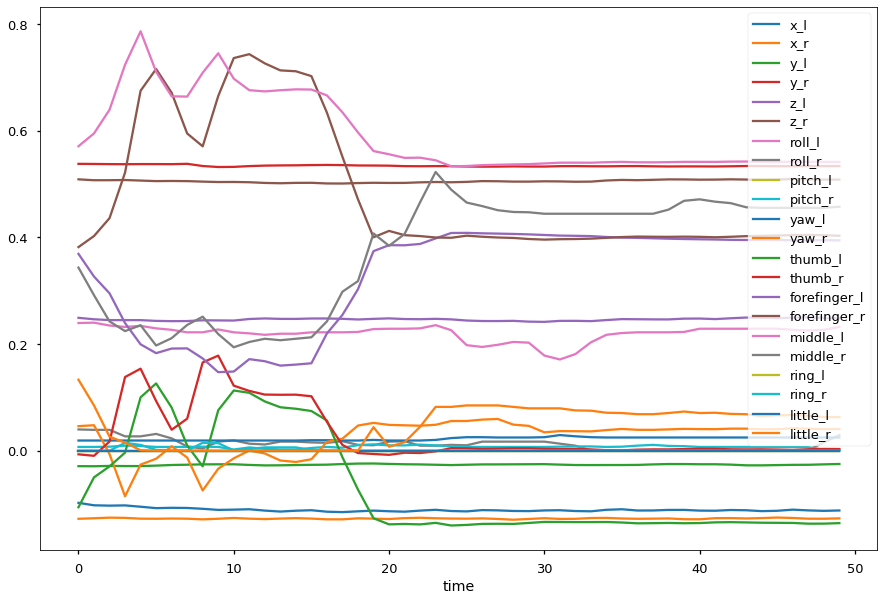

In [39]:
sign0.plot()

Для каждого из "слов" у нас есть набор показаний сенсоров с разных частей руки в каждый момент времени.

Идея нашего подхода будет заключаться в следующем – давайте для каждого сенсора составим набор характеристик (например, разброс значений, максимальное, минимальное, среднее значение, количество "пиков", и т.п.) и будем использовать эти новые "признаки" для решения задачи классификации.

## Расчет новых признаков

Признаки мы будем считать с помощью библиотеки [tsfresh](http://tsfresh.readthedocs.io/en/latest/index.html). Генерация новых признаков может занять много времени, поэтому мы сохранили посчитанные данные, но при желании вы можете повторить вычисления.

In [40]:
from sklearn.preprocessing import LabelEncoder

In [41]:
## Если не хотите долго ждать - не убирайте комментарии
# !pip install tsfresh


# import tsfresh
# from tsfresh.feature_extraction import extract_features
# from tsfresh.feature_selection import select_features
# from tsfresh.utilities.dataframe_functions import impute
# from tsfresh.feature_extraction import ComprehensiveFCParameters, MinimalFCParameters, settings, EfficientFCParameters


# sign_features = extract_features(df_database, column_id='id', column_sort='time',
#                                  default_fc_parameters=EfficientFCParameters(),
#                                  impute_function=impute)

# enc = LabelEncoder()
# enc.fit(sign_classes.loc[:, 'class'])
# sign_classes.loc[:, 'target'] = enc.transform(sign_classes.loc[:, 'class'])

# sign_features_filtered = select_features(sign_features, sign_classes.loc[:, 'target'])

# filepath = './data/tsfresh_features_filt.csv.gz'
# sign_features_filtered.to_csv(filepath, compression='gzip')

In [42]:
!mkdir ./data
!wget https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0 -O ./data/tsfresh_features_filt.csv.gz
filepath = './data/tsfresh_features_filt.csv.gz'
sign_features_filtered = pd.read_csv(filepath, index_col = 0)

--2021-04-08 05:55:23--  https://www.dropbox.com/s/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz [following]
--2021-04-08 05:55:24--  https://www.dropbox.com/s/raw/x6b9mqxlw5ijcuf/tsfresh_features_filt.csv.gz
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc186a0527c75fafccbdf2e71d9a.dl.dropboxusercontent.com/cd/0/inline/BMMZ4IiAUgutp5qtQjjAXY59jeF1YTzLpXuFSKRXyiDzaDtIqQWV4y9corQBzMv-Y6eKjjonE_ZCxLcvVsNjvxaaDOd7TXxxojuH3CAfaxViZF-kQVBk7reLiQM5SBRlbrcF3kux4xLZ-9zsXWDjrIBW/file# [following]
--2021-04-08 05:55:24--  https://uc186a0527c75fafccbdf2e71d9a.dl.dropboxusercontent.com/cd/0/inline/BMMZ4IiAUgutp5qtQjjAXY59jeF1YTzLpXuFS

In [43]:
sign_features_filtered.shape

(2565, 11516)

In [44]:
sign_features_filtered.head()

,ring_r__maximum,"ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""mean""","ring_r__fft_coefficient__attr_""abs""__coeff_2","ring_r__linear_trend__attr_""stderr""",ring_r__quantile__q_0.9,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""max""",ring_r__variance,ring_r__standard_deviation,"ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""max""","ring_r__fft_coefficient__attr_""abs""__coeff_1","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""var""","ring_r__agg_linear_trend__attr_""intercept""__chunk_len_50__f_agg_""var""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""max""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""mean""","little_l__agg_linear_trend__attr_""rvalue""__chunk_len_50__f_agg_""var""","ring_r__fft_coefficient__attr_""imag""__coeff_1","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.0","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_5__f_agg_""min""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""mean""","ring_r__linear_trend__attr_""slope""","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","ring_r__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""var""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""max""","ring_r__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""mean""",ring_r__cid_ce__normalize_False,"ring_r__cwt_coefficients__coeff_9__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.2","ring_r__cwt_coefficients__coeff_10__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_8__w_10__widths_(2, 5, 10, 20)","ring_r__cwt_coefficients__coeff_11__w_10__widths_(2, 5, 10, 20)","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.0","ring_r__cwt_coefficients__coeff_7__w_10__widths_(2, 5, 10, 20)","ring_r__agg_linear_trend__attr_""slope""__chunk_len_50__f_agg_""mean""","ring_r__change_quantiles__f_agg_""var""__isabs_False__qh_1.0__ql_0.4",...,y_r__has_duplicate_max,x_r__large_standard_deviation__r_0.45,x_r__large_standard_deviation__r_0.15000000000000002,yaw_l__symmetry_looking__r_0.25,yaw_l__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.15000000000000002,roll_r__symmetry_looking__r_0.2,forefinger_r__has_duplicate_min,forefinger_r__symmetry_looking__r_0.05,roll_l__symmetry_looking__r_0.15000000000000002,roll_l__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.1,forefinger_r__symmetry_looking__r_0.35000000000000003,z_r__large_standard_deviation__r_0.45,forefinger_r__large_standard_deviation__r_0.2,forefinger_r__large_standard_deviation__r_0.45,yaw_r__large_standard_deviation__r_0.4,forefinger_l__has_duplicate_min,thumb_r__large_standard_deviation__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.35000000000000003,thumb_r__symmetry_looking__r_0.30000000000000004,z_r__symmetry_looking__r_0.35000000000000003,forefinger_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.45,thumb_l__large_standard_deviation__r_0.25,thumb_l__symmetry_looking__r_0.4,thumb_l__symmetry_looking__r_0.1,middle_l__symmetry_looking__r_0.35000000000000003,pitch_l__large_standard_deviation__r_0.45,little_r__symmetry_looking__r_0.2,forefinger_l__large_standard_deviation__r_0.15000000000000002,little_r__symmetry_looking__r_0.15000000000000002,z_l__symmetry_looking__r_0.35000000000000003,roll_r__large_standard_deviation__r_0.25,roll_r__large_standard_deviation__r_0.45,little_r__symmetry_lookin

## Базовая модель

В результате у нас получилось очень много признаков (11516 или больше), давайте применим метод главных компонент, чтобы получить сжатое признаковое представление, сохранив при этом предиктивную силу в модели.

In [45]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Создадим бейзлайн без уменьшения размерности. Гиперпараметры модели подбирались произвольно

In [46]:
sign_features_filtered.columns

Index(['ring_r__maximum',
       'ring_r__agg_linear_trend__attr_"intercept"__chunk_len_50__f_agg_"max"',
       'ring_r__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"mean"',
       'ring_r__fft_coefficient__attr_"abs"__coeff_2',
       'ring_r__linear_trend__attr_"stderr"', 'ring_r__quantile__q_0.9',
       'ring_r__agg_linear_trend__attr_"stderr"__chunk_len_5__f_agg_"max"',
       'ring_r__variance', 'ring_r__standard_deviation',
       'ring_r__agg_linear_trend__attr_"stderr"__chunk_len_10__f_agg_"mean"',
       ...
       'forefinger_l__large_standard_deviation__r_0.15000000000000002',
       'little_r__symmetry_looking__r_0.15000000000000002',
       'z_l__symmetry_looking__r_0.35000000000000003',
       'roll_r__large_standard_deviation__r_0.25',
       'roll_r__large_standard_deviation__r_0.45',
       'little_r__symmetry_looking__r_0.05',
       'pitch_l__symmetry_looking__r_0.05',
       'z_l__large_standard_deviation__r_0.45',
       'little_l__symmetry_looking__r_0.0

In [47]:
# Подготовим данные на вход в модель

# признаки
X = sign_features_filtered.values

# классы
y = sign_classes['class'].values
y
# Будем делать кросс-валидацию на 5 фолдов
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)

In [48]:
base_model = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', KNeighborsClassifier(n_neighbors=9))
])

base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy', n_jobs = -1)

In [49]:
base_cv_scores.mean()

0.9196881091617932

## Метод главных компонент (5 баллов)

* (1) Добавьте в пайплайн `base_model` шаг с методом главных компонент. Начиная с версии 0.18 в sklearn добавили разные солверы для PCA. Дополнитенльно задайте в модели следующие параметры: `svd_solder = "randomized"` и `random_state=123`. Остальные гиперпараметры модели и способ кросс-валидации оставьте без изменений
* (1 + 2) Найдите такое наименьшее количество главных компонент, что качество нового пайплайна превыcит 90%. За +2 бала найдите решение не полным перебором
* (1) Укажите долю объяснённой дисперсии при найденной настройке PCA  (для этого надо обучить PCA на всех данных). Долю объясненной диспекрии можно найти в атрибуте `explained_variance_ratio`

####Задание 1

In [50]:
X.shape, y.shape

((2565, 11516), (2565,))

In [52]:
base_model = Pipeline([('scaler', StandardScaler()),
                  ('pca', PCA(
                              svd_solver = 'randomized', 
                              random_state = 123)),
                  ('clf', KNeighborsClassifier(n_neighbors=9))
])
base_cv_scores = cross_val_score(base_model, X, y, cv=cv, scoring='accuracy', n_jobs = -1)

In [53]:
base_cv_scores

array([0.92592593, 0.90838207, 0.91033138, 0.93177388, 0.92202729])

Важно сделать шкалирование до применения метода гланых компонент. 

####Задание 2

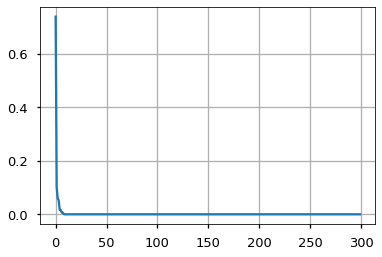

In [76]:
pca_1v = PCA(n_components = 300, svd_solver = 'randomized', random_state = 123).fit((X - X.mean())/X.std())
plt.figure(figsize = (6, 4))
plt.plot(pca_1v.explained_variance_ratio_)
plt.grid(True)
plt.show()

In [82]:
# видно, что большая часть дисперсии "обьяснится" меньше чем при 100 главных компонентах
# пусть тогда верней границей (для поиска колва компонент для точности = 0.9) будет 200 главных компонент, а нижней - нуль

# функция, возвращающая среднее значение по кросс-валидации опр. кол-вом 
# главных компонент 
def return_cv_score(n_comps):
  base_model = Pipeline([('scaler', StandardScaler()),
                    ('pca', PCA(n_components = n_comps,
                                svd_solver = 'randomized', 
                                random_state = 123)),
                    ('clf', KNeighborsClassifier(n_neighbors=9))])
  
  base_cv_scores = cross_val_score(base_model, X, y, cv=cv, 
                                   scoring='accuracy', n_jobs = -1)
  return base_cv_scores.mean(), base_cv_scores

# для поиска использован алгоритм золотого сечения
def find_bound_accure(b_l = 0, b_r = 200):
  phi = 1/1.61
  values = []
  history_x = []
  
  for i in range(20):
    mid_point = b_l + int((b_r-b_l)*phi)

    val = return_cv_score(mid_point)[0]
    if val > 0.9:
      b_r = mid_point
    else:
      b_l = mid_point

    values.append(val)
    history_x.append(mid_point)
    print(f'{i} iter val:{values} \nhist:{history_x}')
    if (val > 0.9) and (return_cv_score(mid_point-1)[0] < 0.9):
      break


    if int((b_r-b_l)*phi) == 0:
      print('Алгоритм не сошелся')
      break
  return mid_point, values, history_x

In [83]:
# Стоит сказать, что алгоритм к сожалению не будет всегда сходиться
# это связано с тем что функция не монотонна и имеет много локальных минимумов и максимумов
# в которых алгоритм и будет застревать при задании определенных интервалов
res = find_bound_accure()

0 iter val:[0.908382066276803] 
hist:[124]
1 iter val:[0.908382066276803, 0.9009746588693958] 
hist:[124, 77]


In [58]:
# для проверки
for i in range(75, 80):
  display(i, return_cv_score(i))

75

(0.8974658869395711,
 array([0.89473684, 0.89668616, 0.91423002, 0.89278752, 0.88888889]))

76

(0.8982456140350876,
 array([0.89668616, 0.89668616, 0.91423002, 0.88888889, 0.89473684]))

77

(0.9009746588693958,
 array([0.90253411, 0.90253411, 0.90838207, 0.89278752, 0.89863548]))

78

(0.8982456140350876,
 array([0.9005848 , 0.89668616, 0.90838207, 0.88888889, 0.89668616]))

79

(0.8959064327485379,
 array([0.89668616, 0.89473684, 0.90838207, 0.88888889, 0.89083821]))

**Ответ: 77**

####Задание 3

График для наглядной зависимости

In [59]:
X_scale = (X - X.mean(axis=0))/X.std(axis = 0)

In [64]:
pca_ = PCA(n_components = 2000, svd_solver = 'randomized', random_state = 123).fit(X_scale)

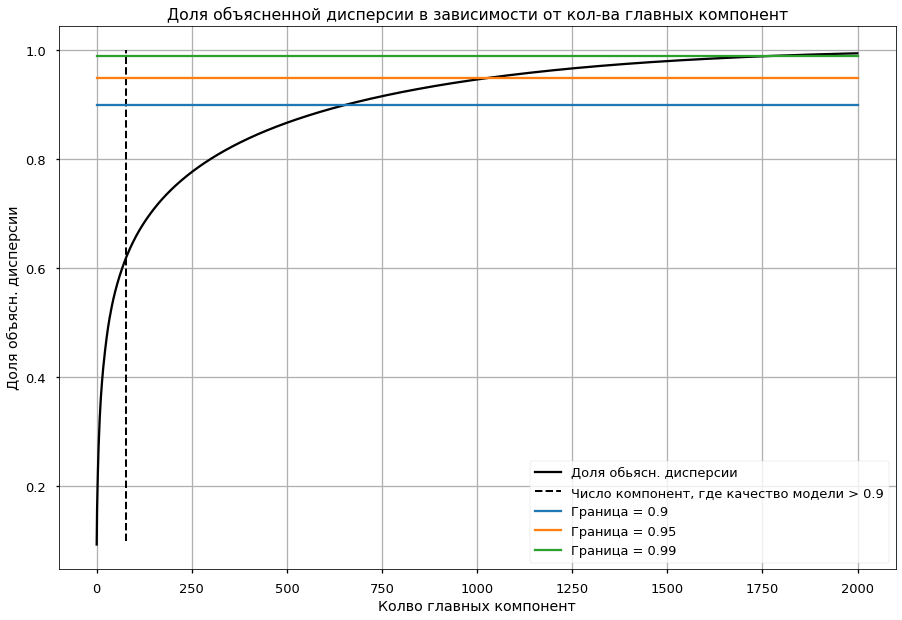

In [65]:
plt.plot(pca_.explained_variance_ratio_.cumsum(), label = 'Доля обьясн. дисперсии', 
         color= 'black')
plt.plot([77,77], [0.1, 1] , label = 'Число компонент, где качество модели > 0.9', 
         color= 'black', linewidth = 2, linestyle = '--')
plt.plot([0, 2000], [0.9, 0.9], label = 'Граница = 0.9')
plt.plot([0, 2000], [0.95, 0.95], label = 'Граница = 0.95')
plt.plot([0, 2000], [0.99, 0.99], label = 'Граница = 0.99')
plt.title('Доля объясненной дисперсии в зависимости от кол-ва главных компонент')
plt.xlabel('Колво главных компонент')
plt.ylabel('Доля объясн. дисперсии')
plt.legend()
plt.grid(True)

In [68]:
# ОТВЕТ
a77 = pca_.explained_variance_ratio_.cumsum()[77]
print(f'Доля объясненной дисперсии при качетсве алгоритма больше 0.9 = {a77}')

Доля объясненной дисперсии при качетсве алгоритма больше 0.9 = 0.6188714428825375


# Задача про кластеризацию текстов

Рассмотрим коллекцию новостных сообщений за первую половину 2017 года. Про каждое новостное сообщение известны:
* его заголовок и текст
* дата его публикации
* событие, о котором это новостное сообщение написано 
* его рубрика 

In [5]:
df = pd.read_csv('news.csv', encoding='utf8')
df.head()

,text,date,event,class
0,В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИС...,2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
1,"Lenta.co, Москва, 14 января 2017 СИТУАЦИЯ С П...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
2,"Аргументы и Факты (aif.ru), Москва, 14 января...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
3,"Google Новости ТОП, Москва, 14 января 2017 АК...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ
4,"Газета.Ru, Москва, 13 января 2017 В МОСКОВСКО...",2017-01-10,Передача РПЦ Исаакиевского собора,Внутренняя политика РФ


In [6]:
df.loc[:, 'class'].value_counts()

Важные мировые события                           403
Внутренняя политика РФ                           364
Внутренняя политика РФ: оппозиция                277
Теракты                                          200
Международные отношения                          153
Спорт                                            102
Проишествия  РФ                                  100
Спорт                                            100
Внутренняя политика: культура                    100
Международные отношения: Криминальная хроника     82
Технологии                                        49
Name: class, dtype: int64

Попробуем кластеризовать документы (каким-либо методом) и сравним полученное разбиение с данными рубликами с помощью ARI

## Стандартная предобработка текстов

Ниже выполняется набор операций по предобработке текстов. Возможно на этом курсе про это не будет идти речь, однако идея довольно простая. Просто следите за комментариями =)

In [7]:
df.text[0] # Так выглядит первая статья до преобработки

' В ПЕТЕРБУРГЕ ПРОШЕЛ МИТИНГ ПРОТИВ ПЕРЕДАЧИ ИСААКИЕВСКОГО СОБОРА РПЦ В Санкт-Петербурге люди устроили акцию протеста против передачи Исаакиевского собора в безвозмездное пользование РПЦ. Жители Петербурга собрались на Исаакиевской площади, чтобы высказаться против передачи Исаакиевского собора в безвозмездное пользование РПЦ, передает ТАСС. Акция проходит в формате встречи с депутатами Законодательного собрания города и не требует согласования с властями. Участники акции не используют какую-либо символику и плакаты, а также мегафоны или средства звукоусиления. По словам депутата Алексея Ковалева, на Исаакиевскую площадь пришло примерно тысяча человек. Перед участниками протеста выступили депутаты местного парламента Борис Вишневский и Максим Резник, которые заявили о том, что потребуют отмены решения Смольного. Вишневский сообщил, что акция будет проходить в виде встречи депутатов с избирателями. "Закон Санкт-Петербурга предоставляет нам право встречаться с избирателями, такую встречу

In [8]:
import re

# Оставляем только кириллические символы
regex = re.compile(u"[А-Яа-я]+")

def words_only(text, regex=regex):
    return " ".join(regex.findall(text))

df.text = df.text.str.lower()
df.loc[:, 'text'] = df.text.apply(words_only)

In [9]:
df.text

0       в петербурге прошел митинг против передачи иса...
1       москва января ситуация с передачей исаакиевско...
2       аргументы и факты москва января оппозиция пров...
3       новости топ москва января акция против передач...
4       газета москва января в московской патриархии п...
                              ...                        
1925    москва сентября кандидат в депутаты в москве п...
1926    москва сентября в избиркомах оценили явку на в...
1927    москва сентября кандидат в столичные депутаты ...
1928    москва сентября медведев припомнил избранным г...
1929    москва сентября жириновский призвал перенести ...
Name: text, Length: 1930, dtype: object

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
from nltk.corpus import stopwords

# Удаляем стоп-слова
mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', u'также',  'т', 'д', '-', '-']
display(df.text)
def  remove_stopwords(text, mystopwords = mystopwords):
    try:
        return u" ".join([token for token in text.split() if not token in mystopwords])
    except:
        return u""
    
df.text = df.text.apply(remove_stopwords)   

0       в петербурге прошел митинг против передачи иса...
1       москва января ситуация с передачей исаакиевско...
2       аргументы и факты москва января оппозиция пров...
3       новости топ москва января акция против передач...
4       газета москва января в московской патриархии п...
                              ...                        
1925    москва сентября кандидат в депутаты в москве п...
1926    москва сентября в избиркомах оценили явку на в...
1927    москва сентября кандидат в столичные депутаты ...
1928    москва сентября медведев припомнил избранным г...
1929    москва сентября жириновский призвал перенести ...
Name: text, Length: 1930, dtype: object

In [12]:
!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
!mkdir -p /root/.local/bin
!cp mystem /root/.local/bin/mystem

--2021-04-08 05:37:46--  http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving download.cdn.yandex.net (download.cdn.yandex.net)... 5.45.205.244, 5.45.205.243, 5.45.205.242, ...
Connecting to download.cdn.yandex.net (download.cdn.yandex.net)|5.45.205.244|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz [following]
--2021-04-08 05:37:47--  http://cache-mskm908.cdn.yandex.net/download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
Resolving cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)... 5.45.220.18, 2a02:6b8:0:2002::19
Connecting to cache-mskm908.cdn.yandex.net (cache-mskm908.cdn.yandex.net)|5.45.220.18|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16457938 (16M) [application/octet-stream]
Saving to: ‘mystem-3.0-linux3.1-64bit.tar.gz’

mystem-3.0-linux3.1 100%[===================>]  1

In [13]:
from pymystem3 import Mystem

# нормализуем текст
m = Mystem('/root/.local/bin/mystem')

In [14]:
def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return ""

df.text = df.text.apply(lemmatize)

In [15]:
mystoplemmas = [u'который', u'прошлый', u'сей', u'свой', u'наш', u'мочь']

# Еще кое-что удаляем
def remove_stoplemmas(text, mystoplemmas = mystoplemmas):
  return "".join([token for token in text if not token in mystoplemmas])


t_n = df.text.apply(remove_stoplemmas)  

In [16]:
display(t_n[0]) # так выгладит первая статья после предобработки

'петербург проходить митинг против передача исаакиевский собор рпц санкт петербург человек устраивать акция протест против передача исаакиевский собор безвозмездный пользование рпц житель петербург собираться исаакиевский площадь высказываться против передача исаакиевский собор безвозмездный пользование рпц передавать тасс акция проходить формат встреча депутат законодательный собрание город требовать согласование власть участник акция использовать какой либо символика плакат мегафон средство звукоусиление слово депутат алексей ковалев исаакиевский площадь приходить примерно тысяча человек участник протест выступать депутат местный парламент борис вишневский максим резник который заявлять потребовать отмена решение смольный вишневский сообщать акция проходить вид встреча депутат избиратель закон санкт петербург предоставлять мы право встречаться избиратель такой встреча проводить рассказывать защищать интерес передача собор сказать парламентарий очередь директор музей исаакиевский собо

## Вычисление сходства (1 балл)

С помощью `TfidfVectorizer` и `pairwise_distances` расчитайте **косинусное** расстояние между всеми парами документов к корпусе.

Про векторизацию текстов с помощью `CountVectorizer` или `TfidfVectorizer` можно почитать [тут](https://www.machinelearningmastery.ru/gentle-introduction-bag-words-model/) 

Запишите результат в переменную `S`

In [17]:
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity

In [18]:
vect = TfidfVectorizer()
texts = t_n.values

In [19]:
# Your Code Here
v = vect.fit_transform(texts)

In [20]:
v

<1930x22688 sparse matrix of type '<class 'numpy.float64'>'
	with 381851 stored elements in Compressed Sparse Row format>

In [21]:
S = pairwise_distances(v)
Cos_ = cosine_similarity(v)

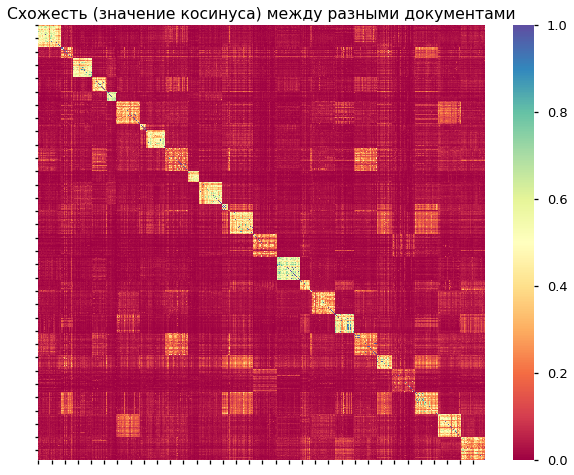

In [22]:
# косинус добавил чтобы перепроверить себя
plt.figure(figsize = (10,8))
sns.heatmap(data=Cos_, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title('Схожесть (значение косинуса) между разными документами')
plt.show()

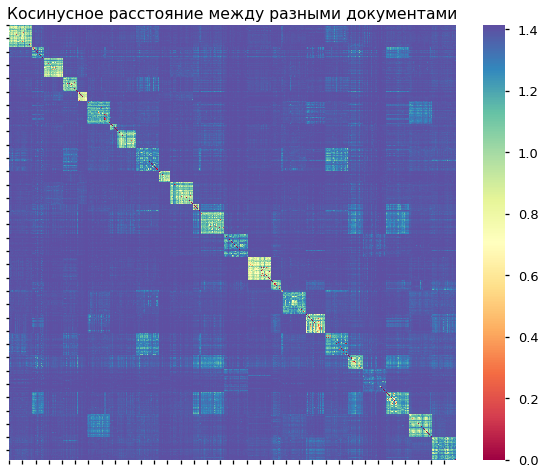

In [23]:
plt.figure(figsize = (10, 8))
sns.heatmap(data=S, cmap = 'Spectral').set(xticklabels=[],yticklabels=[])
plt.title('Косинусное расстояние между разными документами')
plt.show()

Вы должны пронаблюдать, что между некоторыми текстами есть довольно высокое сходство по содержанию слов - мы видим, что вдоль диагонали матрицы попарых расстояний есть "блоки" по похожести. 

Нам конечно же повезло, так как тексты заранее были удачно упорядочены. В реальности такой живописной картины мы скорее всего не увидим.

Попробуем их кластеризовать

## DBSCAN (4 балла)
* (2) Воспользуйтесь методикой оценки параметров для алгоритма DBSCAN. Не копипастите `min_pts = 2` из семинара! Используйте **косинусную** меру близости.
* (1) Выделите кластеры. Для каждого кластера (кроме -1, если он будет) выведите несколько текстов и умозрительно определите его тематику. Можете подсмотреть в исходные тематики корпуса
* (1) Оцените сходство с изначальными рубриками визуально (с помощью матрицы перемешивания) и с помощью [Adjusted Rand Index](https://en.wikipedia.org/wiki/Rand_index)

In [24]:
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import adjusted_rand_score
from sklearn.preprocessing import OrdinalEncoder

####Задание 1

In [25]:
# для нормализованных и предообработанных текстов косинусная мера соотвествует евклидовой метрике
k_neib = 39
metr = 'cosine'
nn = NearestNeighbors(k_neib, metric = metr)

In [26]:
nn.fit(v)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=39, p=2,
                 radius=1.0)

In [27]:
d, id_x = nn.kneighbors(v, return_distance=True)

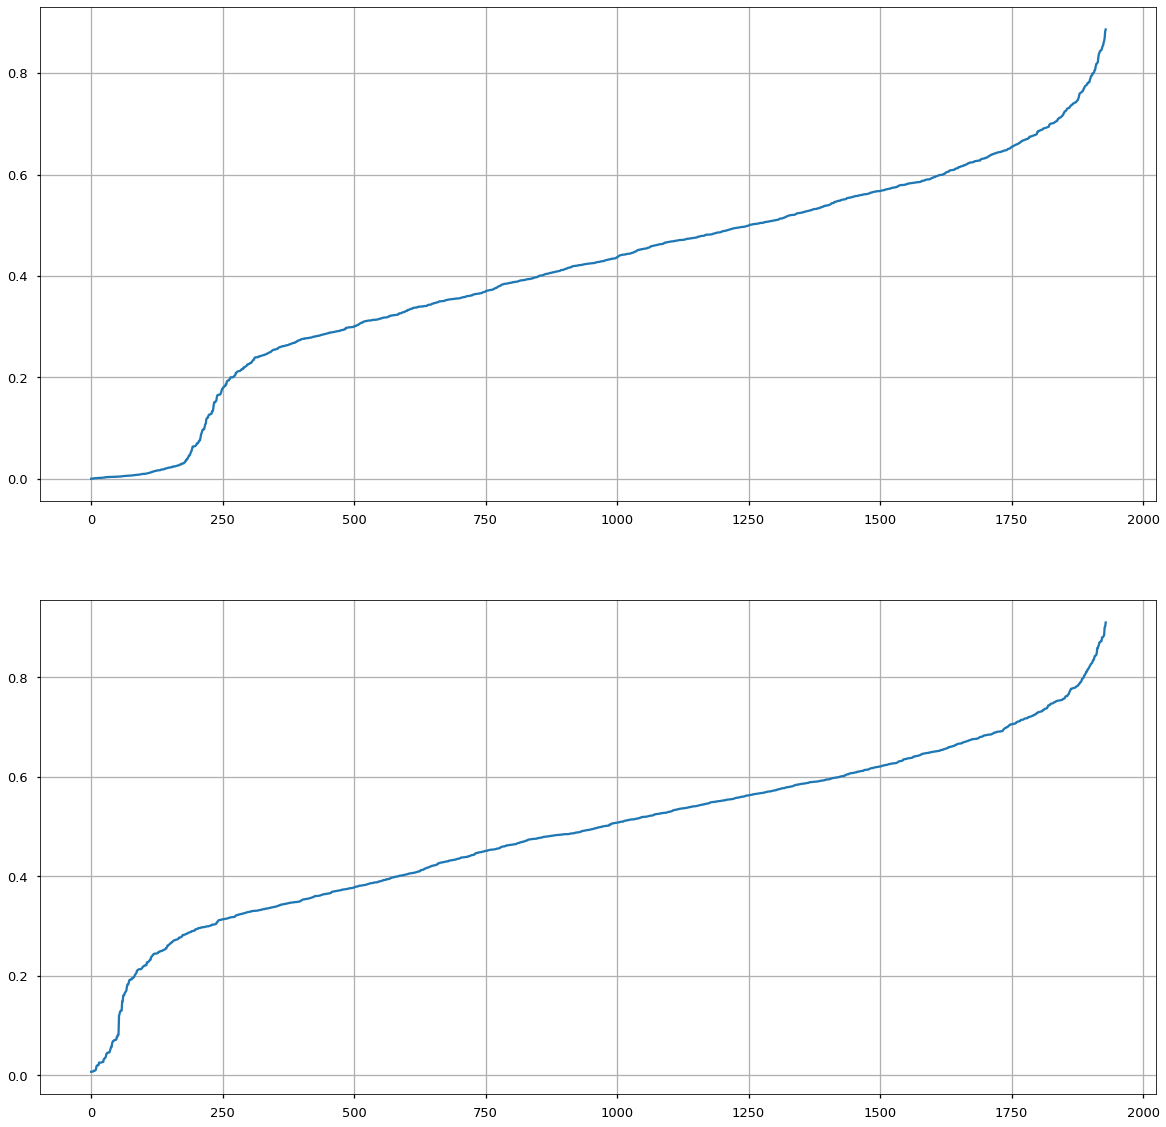

In [28]:
# графики расстояний от точки, для того чтобы оценить eps
fig, ax = plt.subplots(k_neib//10-1, 1, figsize = (20, 10*(k_neib//10-1)))
for i in range(1, k_neib//10):
  e1 = d[:, i*k_neib//10]
  e1.sort()
  ax[i-1].plot(e1)
  ax[i-1].grid(True)

Можно выбирать *eps* в районе (0.6; 0.8), примерно здесь наблюдается скачок. Для интервала (0; 0.2), где скачок тоже, отбирать значение *eps* бессмысленно - расстояние для параметра слишком мало(вывод из экспериментов).

####Задание 2

In [29]:
dbscan = DBSCAN(eps = 0.6699,  min_samples = 39, metric = 'cosine')

In [30]:
dbscan.fit(v)

DBSCAN(algorithm='auto', eps=0.6699, leaf_size=30, metric='cosine',
       metric_params=None, min_samples=39, n_jobs=None, p=None)

In [31]:
labels = dbscan.labels_
np.unique(labels, return_counts = True), (labels == -1).sum()/labels.shape[0]
# метки кластера

((array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
  array([237, 100, 396,  84,  62,  41, 194,  82, 164,  49,  99,  84, 100,
          43,  99,  96])),
 0.12279792746113989)

####Задание 3

In [32]:
true_label = OrdinalEncoder().fit_transform(df.loc[:, 'class'].values.reshape(-1, 1))
pd.crosstab(df.loc[:, 'class'], labels)

col_0,-1,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
class,,,,,,,,,,,,,,,,
Важные мировые события,10,0,225,84,0,41,0,0,0,0,0,0,0,43,0,0
Внутренняя политика РФ,6,100,62,0,0,0,0,0,0,0,0,0,100,0,0,96
Внутренняя политика РФ: оппозиция,50,0,1,0,62,0,0,0,164,0,0,0,0,0,0,0
Внутренняя политика: культура,1,0,0,0,0,0,0,0,0,0,99,0,0,0,0,0
Международные отношения,47,0,106,0,0,0,0,0,0,0,0,0,0,0,0,0
Международные отношения: Криминальная хроника,0,0,0,0,0,0,0,82,0,0,0,0,0,0,0,0
Проишествия РФ,1,0,0,0,0,0,0,0,0,0,0,0,0,0,99,0
Спорт,99,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Спорт,19,0,0,0,0,0,0,0,0,0,0,83,0,0,0,0


In [33]:
print('Качество кластеризации через DBSCAN =', \
      round(adjusted_rand_score(true_label.ravel(), labels), 5))

Качество кластеризации через DBSCAN = 0.47364
